# Generative Adverserial Network
Implementation of the paper :
* [GANs](https://arxiv.org/pdf/1406.2661.pdf) by I. Goodfellow

In [1]:
from IPython.display import HTML
from celluloid import Camera
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

## Explicit Transformation
Let $U \sim \text{Unif}(0,1)$. It has undergone a transformation $\mathscr{T}:U \rightarrow X $ to produce a new variable $X$ where, 
$$x = \mathscr{T}(u) = u^2+1$$.   
So for us the $p_{\text{data}}$ is the underlying distribution of X.

In [2]:
num_samples = 32000

In [3]:
u = np.array([np.random.rand() for i in range(num_samples)])
x = np.array([1+(i**2) for i in u])

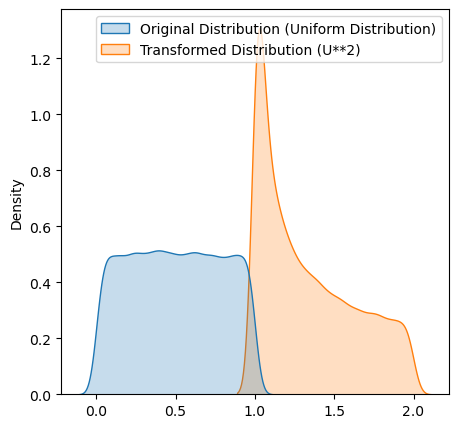

In [4]:
dic = {'Original Distribution (Uniform Distribution)': u,
       'Transformed Distribution (U**2)' : x}
plt.figure(figsize=(5,5))
sns.kdeplot(dic, fill = True)
plt.show()

In the above graph, the transformed distribution in orange is $p_{data}$ that the GAN will try to replicate.

# Generative Adverserial Network

### Prior/ Noise Distribution
We denote the noise with the variable $Z$ denoting the latent space. Z can be any distribution of any dimension. For this setting, Z is taken to be a Multi-Variate Normal Distribution of dimension 50.

In [5]:
latent_dim = 20
output_dim = 1
batch_size = 32

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_dim)
        
    def forward(self, z):
        x = F.relu(self.fc1(z))
        if self.training:
            x = x+torch.randn((x.size(0),x.size(1)))/20
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [8]:
gen = Generator(latent_dim, output_dim)
disc = Discriminator(output_dim)

In [9]:
gen_opt = Adam(gen.parameters(), lr = 0.001)
disc_opt = Adam(disc.parameters(), lr = 0.01)

In [10]:
x = x.reshape(-1, batch_size, 1)
x.shape

(1000, 32, 1)

In [11]:
celoss = torch.nn.BCELoss()

In [12]:
epochs = 5000
disc_steps = 2

fig = plt.figure()
plt.xlim(0,3)
plt.ylim(0,3)
camera = Camera(fig)
for epoch in range(epochs):
    gen.train()
    x = x.reshape(-1, 1)
    np.random.shuffle(x)
    x = x.reshape(-1, batch_size, 1)
    for idx in range(disc_steps):
        batch_idx = np.random.randint(0,len(x))
        batch = torch.tensor(x[batch_idx], dtype=torch.float32)
        z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
        x_fake = gen(z)
        outputs = torch.cat([disc(batch), disc(x_fake)])
        y_ = torch.cat([torch.zeros(x_fake.size(0), 1),torch.ones(x_fake.size(0), 1)])
        disc_score = (celoss(outputs, y_))
        disc_score.backward()
        disc_opt.step()
        disc_opt.zero_grad()
        gen_opt.zero_grad()
            
    z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
    gen_score = celoss(disc(gen(z)), torch.zeros(x_fake.size(0), 1))
    gen_score.backward()
    gen_opt.step()
    disc_opt.zero_grad()
    gen_opt.zero_grad()
        
    if (epoch+1)%5 == 0 or epoch == 0:
        gen.eval()
        z = torch.randn(size=(num_samples, latent_dim), requires_grad=False)
        x_gen = gen(z).detach().numpy().reshape(-1)
        map_final = {'Original Distribution': x.reshape(-1), 'Generator Distribution': x_gen}
        plot = sns.kdeplot(map_final, fill = True) 
        camera.snap()
    if (epoch+1) % 100 == 0:
        print(f"{epoch+1}/{epochs} Discriminator : {disc_score.item():.2f} Generator : {gen_score.item():.2f}")
plt.close()

100/5000 Discriminator : 0.64 Generator : 0.72
200/5000 Discriminator : 0.67 Generator : 0.85
300/5000 Discriminator : 0.67 Generator : 0.80
400/5000 Discriminator : 0.68 Generator : 0.76
500/5000 Discriminator : 0.68 Generator : 0.83
600/5000 Discriminator : 0.69 Generator : 0.74
700/5000 Discriminator : 0.70 Generator : 0.70
800/5000 Discriminator : 0.69 Generator : 0.70
900/5000 Discriminator : 0.65 Generator : 0.71
1000/5000 Discriminator : 0.71 Generator : 0.69
1100/5000 Discriminator : 0.70 Generator : 0.69
1200/5000 Discriminator : 0.69 Generator : 0.69
1300/5000 Discriminator : 0.69 Generator : 0.78
1400/5000 Discriminator : 0.69 Generator : 0.69
1500/5000 Discriminator : 0.70 Generator : 0.70
1600/5000 Discriminator : 0.70 Generator : 0.67
1700/5000 Discriminator : 0.68 Generator : 0.74
1800/5000 Discriminator : 0.68 Generator : 0.96
1900/5000 Discriminator : 0.66 Generator : 0.93
2000/5000 Discriminator : 0.65 Generator : 0.78
2100/5000 Discriminator : 0.64 Generator : 0.83
2

In [13]:
animation = camera.animate(repeat=False)
HTML(animation.to_html5_video())